# Modèles 

In [182]:
import pandas as pd
import numpy as np

from statistics import mean 

Dans cette partie on va essayer d'utiliser des modèles d'apprentissage machine pour prédire les scores des joueurs. On commence par récupérer le dataset et le mettre en forme pour l'apprentissage.

Les choix que l'on fait sont les suivants :
  - On ne garde pas les variables qui dépendent du match :
      - list_var_avg + WIN
  - On ne garde pas les variables qui nous donne aucune information : 
      - SEASON_ID, GAME_ID
  - On modifie le type de la variable PLAYER_ID pour pas qu'elle soit considérée comme un nombre
  - On ne garde pas les variables agrégées sur les équipes car elles sont trop souvent `Nan` car les équipes ne se jouent pas souvent (4 fois max)

In [183]:
# La liste des variables dont on va récupérer les moyennes
list_var_avg = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FTM', 'FG3M',
                 'TOV', 'FGF', 'FG3F', 'FTF', 'BONUS', 'MALUS', 'SCORE']

In [184]:
# Récupere le dataset
df = pd.read_csv('../data/boxscore_2019_final.csv')

df = df.drop(list_var_avg[:-1]+['WIN', 'SEASON_ID', 'GAME_ID'], axis=1)
df = df[~df.AVG_SCORE.isna()]

df.PLAYER_ID = df.PLAYER_ID.astype(object)

# Pour l'instant on retire aussi les variables de moyenne par équipe car elles 
# sont trop souvant vide
df = df.drop(['AVG_ADD_'+x for x in list_var_avg]+['AVG_BONUS', 'AVG_MALUS', 'AVG_SCORE'], axis=1)

In [185]:
df.sample(3)

,PLAYER_ID,GAME_DATE,TEAM,ADV,HOME,SCORE,AVG_PTS,AVG_REB,AVG_AST,AVG_STL,AVG_BLK,AVG_FGM,AVG_FTM,AVG_FG3M,AVG_TOV,AVG_FGF,AVG_FG3F,AVG_FTF,NB_VIC,NB_VIC_ADD
18580,1628973,2020-02-01,DAL,ATL,True,41,10.333333,2.000000,2.666667,0.333333,0.333333,4.000000,2.000000,0.333333,2.000000,4.0,0.666667,0.333333,0,0
4048,202340,2019-12-29,LAL,DAL,True,2,5.333333,2.000000,0.666667,0.000000,0.000000,2.333333,0.000000,0.666667,1.000000,5.0,2.666667,0.000000,1,1
5524,202738,2020-01-23,WAS,CLE,False,15,9.000000,1.333333,2.000000,0.333333,0.000000,3.333333,0.333333,2.000000,2.333333,3.0,1.666667,0.333333,0,0


## 1 - Modèles linéaires

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [143]:
def afficher_model(model, X, y):
    plt.figure(figsize=(8,8))

    plt.scatter(y, model.predict(X))
    plt.plot([0,100], [0,100], color='red', label='bissectrice')

    plt.title('Le score pour chaque match et chaque joueur comparé à notre prédiction',
              fontsize=15)
    plt.xlabel('Score réel', fontsize=15)
    plt.ylabel('Score prédit', fontsize=15)

    plt.legend()
    plt.show()

In [144]:
# On sépare notre base en les variables explicatives et la variable expliquée.
X = df.drop(['SCORE', 'GAME_DATE'], axis=1)
y = df.SCORE

# On choisi un hyperparamètre aléatoirement
alpha=0.2

### Ridge

In [145]:
model = Ridge(alpha=alpha)
model.fit(X,y)

R = model.score(X, y)
MSE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MSE:.3}')

R^2 = 0.459, MSE = 8.23


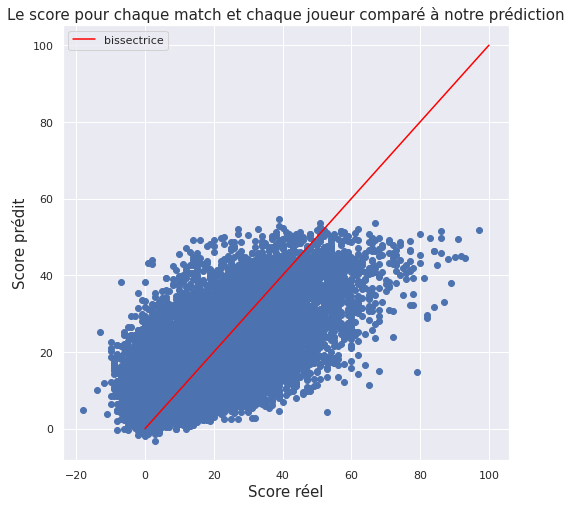

In [146]:
afficher_model(model, X, y)

### Lasso

In [149]:
model = Lasso(alpha=alpha)
model.fit(X,y)

R = model.score(X, y)
MSE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MSE:.3}')

R^2 = 0.392, MSE = 8.75


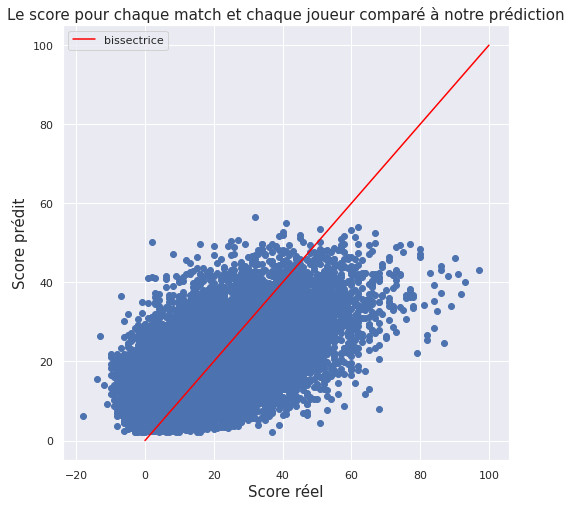

In [150]:
afficher_model(model, X, y)

## 2 - Séparation de la base

Pour pouvoir évaluer les différents modèles que nous allons utiliser Sélim nous a conseiller de faire une *K-fold cross validation* qui très grossièrement consiste à tester son modèles sur différentes partie du data set pour mesurer sa robustesse.

Dans le cas de données temporelles on ne peut pas simplement prendre des parties aléatoires car on risquerait d'avoir des données du futur dans notre base d'entrainement et des données du passé dans celle de test. On se base sur cet [article](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4) pour les différentes méthodes de *cross-validation* dans des séries temporelles.

Les deux méthodes simples que l'on retient sont :
  - *Time Series Split Cross-Validation*
  - *Blocked Cross-Validation*

IMAGE 1 // IMAGE 2

La deuxième est utilisé lorsque l'on suspecte que connaitre des données futurs peut permetre de prédire plus précisément des données passées. Comme nous partons du principe que la probabilité de faire un bon score ne dépend que du passé et jamais du futur nous avons décidé d'implémenter la méthode *Time Serie Split Cross-Validation*

In [186]:
# Le nombre de cross validation+1 que l'on veut
K=6

In [188]:
# On transforme les variables catégorielles en encodage oneshot
df_model = pd.get_dummies(df, columns=['PLAYER_ID', 'TEAM', 'ADV'])

# On récupère les dates pour les séparer en K parties
dates = df.GAME_DATE.sort_values().unique()

# On crée les critères de séléction la base
criteres = [df_model.GAME_DATE.between(x[0], x[-1]) for x in 
                                                    np.array_split(dates, K)]
valeurs = range(K)

# On créé la variable de découpe
df_model = df_model.assign(SPLIT=np.select(criteres, valeurs, df.GAME_DATE))

# On créé les dataframes
df_model.groupby('SPLIT').size().to_frame(name='SIZE')

,SIZE
SPLIT,
0,4358
1,4775
2,4653
3,4644
4,3211
5,853


On remarque que la dernière partie ne contient que très peu d'entrées. On l'explique par le fait que l'on a séparer les groupes en se basant sur les dates et non sur le nombre de match entre deux dates. À la fin de la saison on se retrouve avec les playoff donc il y a beaucoup moins de match. Pour équilibrer on va concatener les deux dernières parties.

In [189]:
lst_df = []

for _, df_split in df_model.drop('GAME_DATE', axis=1).groupby('SPLIT'):
    lst_df += [df_split]

last_df = lst_df.pop()
lst_df[-1] = pd.concat([lst_df[-1], last_df])

In [190]:
[len(x) for x in lst_df]

[4358, 4775, 4653, 4644, 4064]

On se retrouve donc avec K-1 bases de données assez équilibrées sur lesquelles on peut tester les modèles de machines learnings. On automatise tous ça et le calcul avec une fonction.

In [193]:
def time_split_cross_validation(df, model, K=6):
    '''Calcul le score d'un modèle en utilisant time split cross validation
    
    Args :
        df : la dataframe
        model : le modele que l'on veut utilisé
        K : le nombre de fold
    
    Return :
        La R^2 et le MSE moyen sur les folds
    '''
    
    # On transforme les variables catégorielles en encodage oneshot
    df = pd.get_dummies(df, columns=['PLAYER_ID', 'TEAM', 'ADV'])

    # On récupère les dates pour les séparer en K parties
    dates = df.GAME_DATE.sort_values().unique()

    # On crée les critères de séléction la base
    criteres = [df.GAME_DATE.between(x[0], x[-1]) for x in np.array_split(dates, K)]
    valeurs = range(K)

    df = df.assign(SPLIT=np.select(criteres, valeurs, df.GAME_DATE))
    df.groupby('SPLIT').size().to_frame(name='SIZE')
    
    # On crée la liste des dataframes
    lst_df = []

    for _, df_split in df.drop('GAME_DATE', axis=1).groupby('SPLIT'):
        lst_df += [df_split]

    last_df = lst_df.pop()
    lst_df[-1] = pd.concat([lst_df[-1], last_df])
    
    # On calcul les scores moyens pour chaque dataframe
    R_score = []
    MSE_score = []
    for i, df_test in enumerate(lst_df[1:]):
        df_train = pd.concat(lst_df[:i+1])

        X_train, y_train = df_train.drop('SCORE', axis=1), df_train.SCORE
        X_test, y_test = df_test.drop('SCORE', axis=1), df_test.SCORE

        model.fit(X_train, y_train)

        R_score += [model.score(X_train, y_train)]
        MSE_score += [mean_absolute_error(model.predict(X_test), y_test)]

    return(mean(R_score), mean(MSE_score))

In [194]:
model = Ridge(alpha=0.1)
time_split_cross_validation(df, model)

(0.47684690609003966, 8.889356133438515)

## 3 - Grid search (Hyperparamètre)

On a pour ces deux modèles de régressions un hyperparamètre `alpha`. Pour pouvoir le choisir il faut faire ce qu'on le fasse varier puis on mesure et on choisit la meilleure.